In [1]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda

GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
pwd

'/coc/scratch/sanisetty3/music_motion/motion_vqvae'

## VQ

In [14]:
from core.quantization.vector_quantize_pytorch import VectorQuantize
from core.models.encdec import Decoder,Encoder
from core.models.conv_vqvae import VQMotionModel

In [15]:
from einops import pack , rearrange, unpack

In [16]:
from configs.config import cfg, get_cfg_defaults


cfg_vq = get_cfg_defaults()
cfg_vq.merge_from_file("/srv/scratch/sanisetty3/music_motion/motion_vqvae/checkpoints/conv_vq/convq_768_1024_affine/convq_768_1024_affine.yaml")




In [17]:
vqmotionmodel = VQMotionModel(cfg_vq.vqvae)

In [18]:
decoded_motion_features , indices, commit_loss = vqmotionmodel(torch.randn((4,64,263)))


In [21]:
decoded_motion_features.shape

torch.Size([4, 64, 263])

In [20]:
indices.shape

torch.Size([4, 8])

In [29]:
quant = vqmotionmodel.vq.get_codes_from_indices(indices)

In [24]:
6144/768

8.0

In [32]:
vqmotionmodel.motionDecoder(quant.reshape(quant.shape[0] , -1  , 768)).shape

torch.Size([4, 64, 263])

In [6]:
vq = VectorQuantize(
    dim = 768,
    codebook_size = 1024,     # codebook size
    decay = 0.8,             # the exponential moving average decay, lower means the dictionary will change faster
    commitment_weight = 5.,   # the weight on the commitment loss
    kmeans_init = True,   # set to True
    kmeans_iters = 10 ,
    threshold_ema_dead_code = 2,
    sync_codebook = False,
    sync_affine_param = False,
    sync_kmeans=  False,
    
    
    learnable_codebook = True,
    in_place_codebook_optimizer = lambda *args, **kwargs: torch.optim.SGD(*args, **kwargs, lr=1.0, momentum=0.9),
    
    affine_param = True,
    affine_param_batch_decay = 0.99,
    affine_param_codebook_decay = 0.9,
    ema_update = False,
    
    
)


In [7]:
x = torch.randn(1, 1024, 768)
quantized, indices, commit_loss = vq(x)

In [29]:
x = torch.randn(4, 1024, 263)


In [52]:
encoder = Encoder(263, 768, 3, 2, 768, 3, 3, activation='relu', norm=None)
decoder = Decoder(263, 768, 3, 2, 768, 3, 3, activation='relu', norm=None)

In [53]:
x = torch.randn(4, 1024, 263)
x_encoder = encoder(x)


In [54]:
x_encoder.shape

torch.Size([4, 128, 768])

In [55]:
quantized, indices, commit_loss = vq(x_encoder)

In [56]:
quantized.shape

torch.Size([4, 128, 768])

In [57]:
x_decoder = decoder(quantized)
x_decoder.shape

torch.Size([4, 1024, 263])

In [58]:
out.shape

torch.Size([4, 1024, 263])

## Dataset

In [34]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import os

In [195]:
t2m = glob("/srv/scratch/sanisetty3/music_motion/HumanML3D/HumanML3D/new_joint_vecs/*.npy")
aist = glob("/srv/scratch/sanisetty3/music_motion/AIST/new_joint_vecs/*.npy")
choreomaster= glob("/srv/scratch/sanisetty3/music_motion/Choreomaster/new_joint_vecs/*.npy")

In [230]:
choreomaster2= sorted(glob("/srv/scratch/sanisetty3/music_motion/Choreomaster/joint_indices/1010/*.npy"))

In [231]:
np.load("/srv/scratch/sanisetty3/music_motion/Choreomaster/new_joint_vecs/1010.npy").shape

(3232, 263)

In [35]:
files = sorted(glob("/srv/scratch/sanisetty3/music_motion/Choreomaster/new_joint_vecs/*.npy"))
file_names = [os.path.basename(_).split(".")[0] for _ in files]

In [ ]:
np.random.choice(file_names , 0.8)

In [36]:
with open("/srv/scratch/sanisetty3/music_motion/Choreomaster/all.txt", "w") as txt_file:
    for line in file_names:
        txt_file.write(line + "\n") 

In [37]:
36*0.8

28.8

63.2

In [228]:
import datetime
str(datetime.timedelta(seconds=(c71/24)))

'0:02:14.708333'

In [140]:
709/20

35.45

In [69]:
all_motions = t2m + aist + choreomaster

In [93]:
print(len(t2m))
print(len(aist) + len(t2m))
print(len(choreomaster))

29228
31954
72


In [76]:
lens = []
for i in all_motions:
    lens.append(np.load(i).shape[0])

In [91]:
np.argmax(lens)

31984

In [86]:
np.mean(lens)

158.6747018047836

In [87]:
np.var(lens)

35160.657873084434

In [137]:
sum(np.array(lens) >= 60)

29398

In [135]:
sum(np.array(lens) < 60)

2628

(array([  180.,  1020.,  1428.,  2792.,  3230.,  2894.,  2076.,  2874.,
         2106., 12158.]),
 array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.]),
 <BarContainer object of 10 artists>)

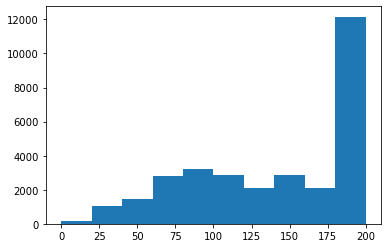

In [133]:
plt.hist(lens , bins = 10, range = (0,200))

In [97]:
username="sohananisetty630@gmail.com"
password="!Mindstormev3"

In [105]:
# !wget --post-data "username=$username&password=$password" --no-check-certificate "https://download.is.tue.mpg.de/download.php?domain=moyo&resume=1&sfile=MOYO/20220923_20220926_with_hands/mosh.zip"

In [103]:
# !wget --post-data "username=$username&password=$password" --no-check-certificate  "https://download.is.tue.mpg.de/download.php?domain=moyo&resume=1&sfile=MOYO/20221004_with_com/mosh.zip"

In [108]:
!unzip mosh1.zip

Archive:  mosh1.zip
replace mosh/train/220923_yogi_body_hands_03596_Split_pose-b_stageii.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [109]:
with open('mosh2/train/220923_yogi_body_hands_03596_Boat_Pose_or_Paripurna_Navasana_-a_stageii.pkl', 'rb') as f:
    x = pickle.load(f)


In [113]:
x.keys()

dict_keys(['fullpose', 'trans', 'stageii_debug_details', 'betas', 'markers_latent', 'latent_labels', 'marker_meta', 'markers_latent_vids', 'v_template_fname', 'stagei_debug_details'])

In [114]:
x["fullpose"].shape

(892, 165)

In [115]:
x["trans"].shape

(892, 3)